### Algorithms Assignment 4 - DDS Discrimination Analysis
_Yuanqi (Edward) Hong_  
Columbia University, Spring 2019

**Summary**
- **Data**: A sample of 1000 DDS "consumers." Variables mainly include `Age`, `Gender`, `Expenditures`, and `Ethnicity`.
- **Analysis goal**: Answer the question "Is there ethnicity-based discrimination in the distribution of DDS's expenditures? i.e. Is there at least one ethnicity group that's systematically getting lower or higher funds than others?" Sidenote: We're asked to analyze for discrimination against any group, but I decided to narrow down to ethnicity-based discrimination. Nevertheless, `Gender`- and `Age`-based discrimination are accounted for in the analysis.
- **Method**: Mainly linear regression.
- **Dependent variable**: `Expenditures`. This variable describes how much money a certain consumer get. We're interested in how this number is or is not affected by some characteristics of the individual, especially his or her ethnicity.
- **Independent variables**: `Age`, `Gender`, and `Ethnicity`. We're particularly interested in `Ethnicity`. `Age` and `Gender` could be considered as control variables.
- **Conclusion**: Age explains a lot of the differences in how much expenditures a consumer is getting. No gender-based discrimination is evident. No ethnicity-based discrimination is evident _overall_, but something seems to be going on between `White not Hispanic` and `Hispanic`, which merits further analyses. Our data do not include the type of developmental disabilities so we couldn't control for that in the analysis, and this seems to be an important factor in the decision process of the level of `Expenditures`, so again, more data / analysis is needed.

In [1]:
# imports
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.style as style

# set the style of plots
style.use('seaborn')

In [2]:
# load the data into a pandas dataframe and check out the first few rows
df = pd.read_csv('dds_data.csv')
df.head()

,ID,Age_Cohort,Age,Gender,Expenditures,Ethnicity
0,10210,13-17,17,Female,2113,White not Hispanic
1,10409,22-50,37,Male,41924,White not Hispanic
2,10486,0 - 5,3,Male,1454,Hispanic
3,10538,18-21,19,Female,6400,Hispanic
4,10568,13-17,13,Male,4412,White not Hispanic


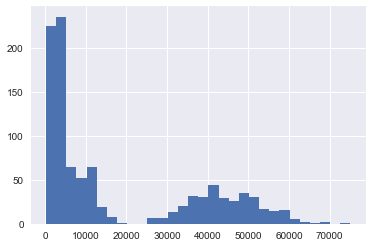

In [3]:
# plot a histogram on the expenditures to get a quick look of the data
df.Expenditures.hist(bins=30)
plt.show()

From the above histogram, we can see that the expenditures aren't normally distributed. The histogram has a peak at low levels (<10000), indicating the fact that a large number of consumers don't get amounts bigger than 10000; a second minor peak appears at around 40000, which is part of what seems to be a normally distributed subset of the expenditures (above 20000). The most interesting point here is probably the gap from around 20000 to 25000. Why the gap?

Keeping that in mind, I plotted a histogram for `Age`.

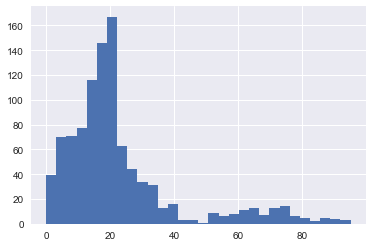

In [4]:
df.Age.hist(bins=30)
plt.show()

The shape looks suspiciously familiar (to what we've seen in the `Expenditures` histogram). Let's go ahead and plot `Expenditures` against `Age`.

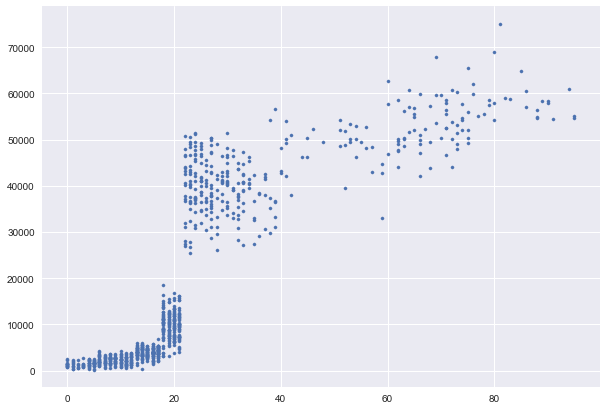

In [5]:
plt.figure(figsize=(10, 7)) # sets the figure size
plt.scatter(df['Age'], df['Expenditures'], s=10) # the 's' parameter sets the marker size
plt.show()

This is one of those **_Aha_** moments. The upper trend and the **leap** in the scatterplot indicate that `Age` might be quite powerful in explaining how much money an individual gets. This phenomenon is worth pondering upon. One could be tempted to frame this in an age-based discrimination lens, but the leap here is too abrupt for such viewpoints to be compelling. I'm inclined to think that this is due to some regulatory or other kinds of reasons. The following figure from the DDS fact book gives further information.

<img src='avg-exp-disabilities-age.png' width=700>

From the above figure, we could see that:
- The average per capita expenditures increase with age. This reminds us that in later regressions, `Age` should definitely be included as control variable.
- Average expenditures vary systematically from one type of developmental disability to another, especially in older age cohorts. This reminds us that with the data we have, which don't include a variable specifying the type of disability, any conclusion reached should be taken with a pinch of salt, since the type of disability isn't controlled for.

In [6]:
# *going off of that, we take a quick look at the age cohorts
df['Age_Cohort'].value_counts()

22-50     226
13-17     212
18-21     199
6-12      175
 51 +     106
 0 - 5     82
Name: Age_Cohort, dtype: int64

In [7]:
# use value_counts() on the interested independent variable to get a sense of the distribution of ethnicities
df['Ethnicity'].value_counts()

White not Hispanic    401
Hispanic              376
Asian                 129
Black                  59
Multi Race             26
American Indian         4
Native Hawaiian         3
Other                   2
Name: Ethnicity, dtype: int64

Notice that `Multi Race`, `American Indian`, `Native Hawaiian`, and `Other` all have less than 30 observations.

In [8]:
# group the data by ethnicity and take the mean of expenditures in each group
# sort the results in descending order
df.groupby(['Ethnicity'])['Expenditures'].mean().sort_values(ascending=False)

Ethnicity
Native Hawaiian       42782.333333
American Indian       36438.250000
White not Hispanic    24697.548628
Black                 20884.593220
Asian                 18392.372093
Hispanic              11065.569149
Multi Race             4456.730769
Other                  3316.500000
Name: Expenditures, dtype: float64

In [9]:
# do the same thing but this time compute median instead of mean
df.groupby(['Ethnicity'])['Expenditures'].median().sort_values(ascending=False)

Ethnicity
American Indian       41817.5
Native Hawaiian       40727.0
White not Hispanic    15718.0
Asian                  9369.0
Black                  8687.0
Hispanic               3952.0
Other                  3316.5
Multi Race             2622.0
Name: Expenditures, dtype: float64

Native Hawaiians have the highest average expenditures, American Indians have the highest median, but there're only 3 and 4 people in these groups, respectively. If we ignore groups with less than 30 records, we see that white-not-hispanics have both the highest mean and median expenditures.

Another way to look at this would be to first break down the sample into those who receive 20000 or less, and those who get more than 20000, and see the percentage of each ethnicity in those two group respectively.

In [10]:
# before moving on, go ahead and exclude the ethnicities groups with fewer than 30 observations
df = df[(df.Ethnicity != 'Multi Race') &
        (df.Ethnicity != 'American Indian') &
        (df.Ethnicity != 'Native Hawaiian') &
        (df.Ethnicity != 'Other')]

In [11]:
# look at ethnicity breakdown for the group receiving 20000 or less
df[df['Expenditures']<=20000]['Ethnicity'].value_counts(normalize=True)

Hispanic              0.493750
White not Hispanic    0.315625
Asian                 0.135937
Black                 0.054688
Name: Ethnicity, dtype: float64

In [12]:
# look at ethnicity breakdown for the group receiving more than 20000
df[df['Expenditures']>20000]['Ethnicity'].value_counts(normalize=True)

White not Hispanic    0.612308
Hispanic              0.184615
Asian                 0.129231
Black                 0.073846
Name: Ethnicity, dtype: float64

We can see that `Hispanic` and `White not Hispanic` swap places in the two subgroups, while `Asian` and `Black` remain their relative ranking order. This information is useful for later regression analysis.

To dig a little deeper into this, I first break the data down into two groups, one containing people aged 21 or less, the other containing the rest. The idea of this breakdown comes from the leap we observed earlier when we plotted `Expenditures` against `Age`. Given the obvious correlation between `Age` and `Expenditures`, this might seem a bit redundant, but actually we're looking at the data from two different perspectives, so it's worth the effort.

In [13]:
# break the data into two large age groups
# for simplicity, just for simplicity, I call these 'young' and 'old'
young = df[df.Age <= 21]
old = df[df.Age > 21]

In [14]:
# for the 'young' group, look at the ethnicity breakdown
young['Ethnicity'].value_counts(normalize=True)

Hispanic              0.493750
White not Hispanic    0.315625
Asian                 0.135937
Black                 0.054688
Name: Ethnicity, dtype: float64

In [15]:
# just to make sure, I check for the number of people who are in the 'young' group and also getting more than 20000
# turns out there's none, which is consistent with earlier observations
len(young[young['Expenditures']>20000]['Ethnicity'].value_counts(normalize=True))

0

In [16]:
# now we look at the 'old' group's ethnicity breakdown
old['Ethnicity'].value_counts(normalize=True)

White not Hispanic    0.612308
Hispanic              0.184615
Asian                 0.129231
Black                 0.073846
Name: Ethnicity, dtype: float64

These results are similar to what we got when we broke down the data using the 20000 line.

After the above exploratory analysis, we move on to regressions.

We start off with the following model specification:

$$\hat{Expenditures} = a + b_{1}Age + b_{2}Male + b_{3}Asian + b_{4}Black + b_{5}Hispanic + e$$

I created dummies (or rather, `StatsModels` generates them automatically) for `Gender` and for `Ethnicity`. `StatsModels` drops a dummy for each of these two to avoid [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity). Normally we don't care which one it drops, but in this case, I specifically tell it to drop `White not Hispanic` among the `Ethnicity` dummies. Recall from earlier analysis that `White not Hispanic` seems to be consistently showing up as the group that gets higher expenditures, we want this group to be our baseline in the regression. I use HC1 type covariance for this model.

_Before I decided to use this model specification, I tried to create a dummy just for the `White not Hispanic` group by giving people in this group `1`s and the rest `0`s. Running a regression using this grouping method, however, resulted in something with an adjusted R-squared of 0.077. So._

In [17]:
# Model 1
model = smf.ols(formula='Expenditures ~ Age + Gender + C(Ethnicity, Treatment(reference="White not Hispanic"))', data=df)
results = model.fit()
results_robust = results.get_robustcov_results(cov_type='HC1')

results_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Expenditures   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     451.1
Date:                Mon, 18 Feb 2019   Prob (F-statistic):          6.29e-249
Time:                        23:19:37   Log-Likelihood:                -10294.
No. Observations:                 965   AIC:                         2.060e+04
Df Residuals:                     959   BIC:                         2.063e+04
Df Model:                           5                                         
Covariance Type:                  HC1                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             631.6855    836.852      0.755      0.451   -1010.587    2273.958
Gender[T.Male]                                                       -401.0083    671.855     -0.597      0.551   -1719.484     917.468
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Asian]    -2035.5927   1116.616     -1.823      0.069   -4226.885     155.700
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Black]     -895.8028   1555.904     -0.576      0.565   -3949.172    2157.567
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Hispanic] -4438.6540    780.593     -5.686      0.000   -5970.522   -2906.786
Age                                                                   867.2677     20.579     42.144      0.000     826.883     907.652
==============================================================================
Omnibus:                      148.526   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.657
Skew:                           1.105   Prob(JB):                     3.31e-48
Kurtosis:                       3.743   Cond. No.                         135.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

The result of the above regression shows that most of the coefficients have a p-value higher than the conventional 0.05 level. In fact, only the coefficients of `Hispanic` and `Age` pass the significance test. At the same time, the adjusted R-squared of our model is 0.717. The information we gathered from this is that:
- `Age` is once again corroborated to be powerful in explaining the discrepancies in `Expenditures`;
- No gender-based discrimination is evident;
- Except for `Hispanic`, other ethnicity groups don't differ significantly from `White not Hispanic` in terms of the expenditures they're getting.

Since `Gender` is not statistically significant at all, I drop it and run the regression again.

In [18]:
# Model 2 (Model 1 without controlling for gender)
model = smf.ols(formula='Expenditures ~ Age + C(Ethnicity, Treatment(reference="White not Hispanic"))', data=df)
results = model.fit()
results_robust = results.get_robustcov_results(cov_type='HC1')

results_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Expenditures   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     565.8
Date:                Mon, 18 Feb 2019   Prob (F-statistic):          1.11e-250
Time:                        23:19:37   Log-Likelihood:                -10294.
No. Observations:                 965   AIC:                         2.060e+04
Df Residuals:                     960   BIC:                         2.062e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             439.1774    776.637      0.565      0.572   -1084.925    1963.279
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Asian]    -2051.5858   1116.035     -1.838      0.066   -4241.736     138.564
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Black]     -924.5078   1553.706     -0.595      0.552   -3973.560    2124.545
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Hispanic] -4440.2127    780.500     -5.689      0.000   -5971.896   -2908.529
Age                                                                   867.1427     20.539     42.220      0.000     826.837     907.448
==============================================================================
Omnibus:                      149.130   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.915
Skew:                           1.108   Prob(JB):                     1.76e-48
Kurtosis:                       3.750   Cond. No.                         135.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

The story is not very much different. (There's some improvement in our BIC.)

I decide to run two additional regressions (not controlling for `Gender`, since it's not significant anyway), for each of the two subsets (`young` and `old`).

In [19]:
# Model 3 (Model 2, but for young)
model = smf.ols(formula='Expenditures ~ Age + C(Ethnicity, Treatment(reference="White not Hispanic"))', data=young)
results = model.fit()
results_robust = results.get_robustcov_results(cov_type='HC1')

results_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Expenditures   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     203.3
Date:                Mon, 18 Feb 2019   Prob (F-statistic):          3.88e-112
Time:                        23:19:37   Log-Likelihood:                -5919.3
No. Observations:                 640   AIC:                         1.185e+04
Df Residuals:                     635   BIC:                         1.187e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           -1613.3235    268.250     -6.014      0.000   -2140.088   -1086.559
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Asian]      326.0911    342.476      0.952      0.341    -346.432     998.614
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Black]     -221.7372    351.625     -0.631      0.529    -912.225     468.751
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Hispanic]  -175.2698    233.042     -0.752      0.452    -632.896     282.357
Age                                                                   496.9677     17.919     27.733      0.000     461.779     532.156
==============================================================================
Omnibus:                       73.554   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.616
Skew:                           0.841   Prob(JB):                     8.60e-23
Kurtosis:                       3.991   Cond. No.                         73.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [20]:
# Model 4 (Model 2, but for old)
model = smf.ols(formula='Expenditures ~ Age + C(Ethnicity, Treatment(reference="White not Hispanic"))', data=old)
results = model.fit()
results_robust = results.get_robustcov_results(cov_type='HC1')

results_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Expenditures   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     97.35
Date:                Mon, 18 Feb 2019   Prob (F-statistic):           4.26e-54
Time:                        23:19:37   Log-Likelihood:                -3292.2
No. Observations:                 325   AIC:                             6594.
Df Residuals:                     320   BIC:                             6613.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            3.113e+04    825.143     37.723      0.000    2.95e+04    3.28e+04
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Asian]      315.2445   1099.735      0.287      0.775   -1848.380    2478.869
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Black]      388.2728   1153.856      0.337      0.737   -1881.829    2658.375
C(Ethnicity, Treatment(reference="White not Hispanic"))[T.Hispanic]  1073.3186    923.340      1.162      0.246    -743.264    2889.902
Age                                                                   313.3290     15.956     19.637      0.000     281.936     344.722
==============================================================================
Omnibus:                        0.314   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.855   Jarque-Bera (JB):                0.448
Skew:                          -0.012   Prob(JB):                        0.799
Kurtosis:                       2.820   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Looking at Regression 3 and 4, the intercept p-value drops to a significant level. `Age` is still significant. However, coefficients for all other ethnicity groups become very insignificant, and the adjusted R-squared drops to slightly above 0.5.

**Ref.**
- [StatsModels Formulas: Fitting models using R-style formulas](https://www.statsmodels.org/dev/examples/notebooks/generated/formulas.html)
- [Comparing Stata and Ipython Commands for OLS Models](https://rlhick.people.wm.edu/posts/comparing-stata-and-ipython-commands-for-ols-models.html)
- [Using Heteroscedasticity Consistent Standard Errors in the Linear Regression Model](http://www.indiana.edu/~jslsoc/files_research/testing_tests/hccm/00TAS.pdf)
- [Difference between independent t-test and regression with dummy?](https://www.researchgate.net/post/Difference_between_independent_t-test_and_regression_with_dummy)
- [DDS Fact Book, 15th edition](https://www.dds.ca.gov/FactsStats/docs/factBook_15th.pdf)
- [Specifying which category to treat as the base with 'statsmodels'](https://stackoverflow.com/questions/22431503/specifying-which-category-to-treat-as-the-base-with-statsmodels)